# Driver Drowsiness Alert System

This Jupyter Notebook implements a real-time driver drowsiness detection system. It uses computer vision techniques to analyze a driver's face from a webcam feed, detects signs of fatigue like closed eyes or yawning, and triggers an alert.


In [4]:
# Install specific package versions to resolve dependency conflicts
import sys
!{sys.executable} -m pip install numpy==1.26.4 matplotlib==3.7.1 mediapipe


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 37.0 MB/s  0:00:01 eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for matplotlib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [974 lines of output]
      
      Edit mplsetup.cfg to change the build options; suppress output with --quiet.
      
      BUILDING MATPLOTLIB
            python: yes [3.12.12 (main, Oct  9 2025, 11:07:00) [Clang 17.0.0
                        (clang-1700.3.19.1)]]
          platform: yes [darwin]
             tests: no  [skipping due to configuration]
            macosx: yes [installing]
      
      toml section missing PosixPath('pyproject.toml') does not contain a tool.setuptools_scm section
      toml section missing PosixPath('pyproject.toml') does not contain a tool.setuptools_scm section
      /private/var/folders/60

## 1. Setup and Imports

First, we import the necessary libraries. We need `cv2` for video capture, `dlib` for face and landmark detection, and our custom modules `DrowsinessAnalyzer`.


In [2]:
import cv2
import time
from drowsiness.drowsiness_analyzer import DrowsinessAnalyzer


## 2. Initialize the Drowsiness Analyzer

Next, we create an instance of our `DrowsinessAnalyzer` class. This class encapsulates all the logic for detecting drowsiness, including the face detector and the analysis of facial landmarks.


In [3]:
analyzer = DrowsinessAnalyzer()
print(analyzer)


DrowsinessAnalyzer(EAR_Threshold=0.2, EAR_Frames=20, MAR_Threshold=0.5)


In [4]:
# 4. Image-based demo (no webcam)
# This cell lets you preview the overlay on a static image so you don't need a camera.
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Path to a sample image you can add to the repo (optional)
img_path = 'sample_images/driver1.png'

if os.path.exists(img_path):
    img = cv2.imread(img_path)
else:
    # create a simple synthetic placeholder image if no sample image is present
    img = 255 * np.ones((480, 640, 3), dtype=np.uint8)
    cv2.putText(img, 'SAMPLE DRIVER', (40, 240), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 2)

# Run the analyzer (analyzer should already be created above)
try:
    annotated, is_drowsy, is_yawning = analyzer.analyze_frame(img.copy())
except NameError:
    raise RuntimeError('`analyzer` is not defined. Run the "Initialize the Drowsiness Analyzer" cell first.')

# Convert BGR->RGB for inline display
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 7))
plt.imshow(annotated_rgb)
plt.axis('off')
plt.show()

print('Drowsy:', is_drowsy, 'Yawning:', is_yawning)

RuntimeError: `analyzer` is not defined. Run the "Initialize the Drowsiness Analyzer" cell first.

Loaded 327 events from logs/drowsiness_log.csv
Total events: 327
2025-11-14: Yawn Detected: 11, Drowsiness Detected: 20
2025-11-15: Yawn Detected: 268, Drowsiness Detected: 28


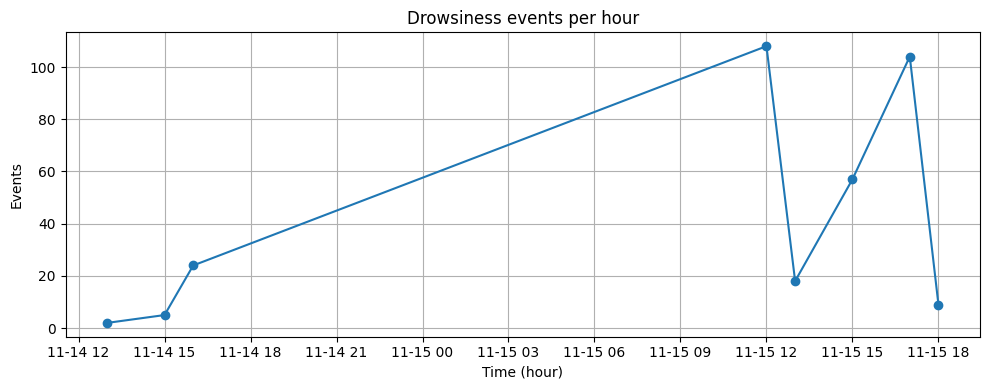

Most recent event: 2025-11-15 18:17:08 Drowsiness Detected
No screenshot available for this event.


In [1]:
# Log analysis demo: read logs, print a summary, plot timeline, and show latest thumbnail (if available)
from tools import log_analysis

log_file = 'logs/drowsiness_log.csv'
events = log_analysis.read_logs(log_file)

print('Loaded', len(events), 'events from', log_file)

# Print a compact summary
log_analysis.print_summary(events)

# If matplotlib is available, plot a simple timeline
try:
    log_analysis.plot_timeline(events)
except Exception as e:
    print('Plotting unavailable or failed:', e)

# Show the thumbnail for the most recent event if one exists
if events:
    latest = events[-1]
    print('Most recent event:', latest['timestamp'].strftime('%Y-%m-%d %H:%M:%S'), latest['event'])
    try:
        log_analysis.show_event_thumbnail(latest)
    except Exception as e:
        print('Thumbnail display unavailable or failed:', e)
else:
    print('No events found in the log file.')


### UI overlay note

The analyzer now displays a top-centered status message when it detects `DROWSY` and/or `YAWNING`.
This is drawn by the analyzer's `draw_status_overlay` helper and will appear in red for `DROWSY` and orange for `YAWNING`.

Behavior note: the status overlay will flash for 1 second after an event (drowsiness or yawn) to draw attention. The flash duration and flash interval are configurable in `DrowsinessAnalyzer` (see `_flash_duration` and `_flash_interval`).


## 3. Real-Time Drowsiness Detection

This is the main part of the program. We start a loop to capture video from the webcam. In each frame, we use our `DrowsinessAnalyzer` to detect signs of fatigue. The frame is then displayed with annotations indicating the Eye Aspect Ratio (EAR), Mouth Aspect Ratio (MAR), and a warning message if drowsiness is detected.

The loop can be stopped by pressing the 'q' key.


In [ ]:
window_name = 'Drowsiness Detection'
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
# Resize the window for better visibility of overlays (optional)
try:
    cv2.resizeWindow(window_name, 1024, 768)
except Exception:
    # Some environments do not support resizeWindow; ignore safely
    pass

try:
    # 0 corresponds to the default webcam.
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise IOError("Cannot open webcam. Please check if the webcam is connected and drivers are installed.")

    while True:
        # Read a frame from the webcam
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame. Exiting...")
            break

        # Analyze the frame for drowsiness
        frame, is_drowsy, is_yawning = analyzer.analyze_frame(frame)

        # Display the resulting frame
        cv2.imshow(window_name, frame)

        # If user closed the window using the window manager, stop cleanly
        try:
            # WND_PROP_VISIBLE is 1.0 when window is visible. If <1, it's closed.
            if cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE) < 1:
                print("Window closed by user.")
                break
        except Exception:
            # Some OpenCV builds/platforms may raise; ignore and continue to keyboard check
            pass

        # Break the loop if 'q' is pressed or ESC
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q') or key == 27:  # 27 = ESC
            break

except (IOError, cv2.error) as e:
    print(f"An error occurred: {e}")
except FileNotFoundError as e:
    print(f"A required file was not found: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

finally:
    # Release the webcam and destroy all windows
    if 'cap' in locals() and cap.isOpened():
        cap.release()

    # Destroy the named window explicitly
    try:
        cv2.destroyWindow(window_name)
    except Exception:
        pass

    # Destroy all windows and give the OS a moment to process the close event
    cv2.destroyAllWindows()
    # ensure the GUI event queue is processed
    try:
        cv2.waitKey(1)
    except Exception:
        pass
    # small pause helps the OS close the window reliably
    time.sleep(0.1)

    print("Webcam released and windows closed.")


Webcam released and windows closed.


: 

In [1]:
from drowsiness.utils import play_alarm
play_alarm(sound_file="./alarm/alert.wav")

<Popen: returncode: None args: ['/usr/bin/afplay', './alarm/alert.wav']>

In [ ]:
import cv2
from drowsiness.mediapipe_analyzer import MediapipeAnalyzer
from drowsiness.drowsiness_analyzer import DrowsinessAnalyzer
import time
import numpy as np

# Initialize analyzers
mediapipe_analyzer = MediapipeAnalyzer()
drowsiness_analyzer = DrowsinessAnalyzer()

# --- Camera and Frame Processing ---
try:
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise IOError("Cannot open webcam")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Mirror the frame horizontally so the preview behaves like a mirror (user-facing).
        # Set to `cv2.flip(frame, 0)` to flip vertically or remove this line to keep raw orientation.
        frame = cv2.flip(frame, 1)

        # --- Drowsiness detection using the analyzer's MediaPipe helper ---
        # This delegates landmark extraction, EAR/MAR computation, overlay drawing,
        # logging and alerting to DrowsinessAnalyzer.analyze_frame_mediapipe().
        frame, is_drowsy, is_yawning = drowsiness_analyzer.analyze_frame_mediapipe(frame, mediapipe_analyzer, draw_landmarks=True)

        cv2.imshow("Drowsiness Detection (MediaPipe)", frame)

        # Break the loop if 'q' is pressed or ESC
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q') or key == 27:  # 27 = ESC
            break
except (IOError, cv2.error) as e:
    print(f"An error occurred: {e}")
finally:
    # if "cap" in locals() and cap.isOpened():
    cap.release()
    # Try to destroy the specific window first (if present)
    try:
        cv2.destroyWindow("Drowsiness Detection (MediaPipe)")
    except Exception:
        pass
    # Process GUI events and then destroy all windows
    try:
        cv2.waitKey(1)
    except Exception:
        pass
    try:
        cv2.destroyAllWindows()
    except Exception:
        pass
    # small pause helps the OS close the window reliably
    time.sleep(0.1)
    # Close analyzers to free native resources (MediaPipe face_mesh etc.)
    try:
        mediapipe_analyzer.close()
    except Exception:
        pass
    try:
        if hasattr(drowsiness_analyzer, "close"):
            drowsiness_analyzer.close()
    except Exception:
        pass
    print("Webcam released and windows closed.")


I0000 00:00:1763249747.224026 7601767 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1763249747.234799 7601842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763249747.237136 7601852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/kedar/Documents/pyproj/aai-551-project-v1/venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Webcam released and windows closed.


: 